In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
df = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Redfin Data\rentals.csv")

df = df[df["Property Type"] == 6]

print(df.columns)

df = df[(df["Max Beds"] > 0 ) & (df["Max Beds"] < 6) & (df["Max Baths"] < 4) & (df["Max Square Feet"] < 5000) & (df["Max Rent Price"] < 10000)]



Index(['Property ID', 'URL', 'Property Type', 'Address', 'City', 'State',
       'ZIP Code', 'Country Code', 'Latitude', 'Longitude', 'Rental ID',
       'Max Beds', 'Max Baths', 'Max Square Feet', 'Max Rent Price',
       'Description', 'cbg_geoid', 'cbsa_geoid', 'cbsa_name', 'state_id',
       'State_Code', 'updated_date'],
      dtype='object')


In [4]:
median_income = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\ACSDT5Y2022.B19013-Data.csv", skiprows=[1], na_values='-')

median_income['GEO_ID'] = median_income['GEO_ID'].astype(str)

# Extracting everything after "US" and storing it in a new column 'cbg_geoid'
median_income['cbg_geoid'] = median_income['GEO_ID'].str.extract('US(\d+)')

median_income['median_income'] = median_income['B19013_001E'].str.replace(',','+').str.replace('+','').str.replace('-','').astype(float)

median_income = median_income[["cbg_geoid", "median_income"]]

epa_cbg_demo = pd.read_csv(r"C:\Users\mattl\OneDrive\Documents\reibrowser\Database\Rent Training Data\EPA_SmartLocationDatabase_V3_Jan_2021_Final (1).csv")

epa_cbg_demo["cbg_geoid"] = \
    epa_cbg_demo["STATEFP"].astype(str).str.zfill(2)  \
    + epa_cbg_demo["COUNTYFP"].astype(str).str.zfill(3) \
    + epa_cbg_demo["TRACTCE"].astype(str).str.zfill(6) \
    + epa_cbg_demo["BLKGRPCE"].astype(str)


cbg_demographics = epa_cbg_demo.merge(median_income, on='cbg_geoid', how="inner")

df["cbg_geoid"] = df["cbg_geoid"].astype(float)
cbg_demographics["cbg_geoid"] = cbg_demographics["cbg_geoid"].astype(float)

df = pd.merge(df, cbg_demographics, on='cbg_geoid', how='inner', suffixes=('_rental', '_demo'))

In [15]:
metadata = [
    "State"
]

features = [
 'Max Beds',
 'Max Baths',
 'Max Square Feet',
 'CBSA_POP',
 'CBSA_EMP',
 'CBSA_WRK',
 'R_HiWageWk',
 'R_PCTLOWWAGE',
 'median_income',
 'TotPop',
#  'Ac_Unpr'
#  'KNN_Rent_Value'
]

target = "Max Rent Price"

df = df[metadata + features + [target]]

# df["Population Density"] = round((df["TotPop"] / df["Ac_Unpr"]) * 640)

# display(df.sort_values("Population Density"))

[]

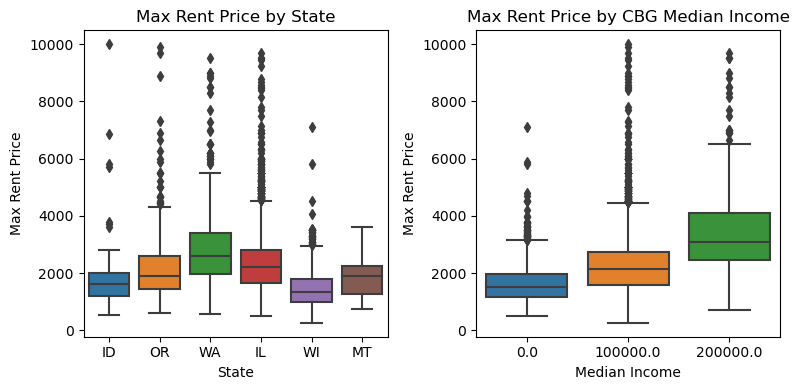

In [12]:
dim = [1,2]

fig, axes = plt.subplots(dim[0], dim[1], figsize = (dim[1]*4, dim[0]*4))

sns.boxplot(y=df["Max Rent Price"], x=df["State"], ax=axes[0])
axes[0].set_title('Max Rent Price by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Max Rent Price')

sns.boxplot(y=df["Max Rent Price"], x= round(df["median_income"]/100000) * 100000, ax=axes[1])
axes[1].set_title('Max Rent Price by CBG Median Income')
axes[1].set_xlabel('Median Income')
axes[1].set_ylabel('Max Rent Price')

# Adjust layout
plt.tight_layout()

plt.plot()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

clean_df = df.dropna(subset=features + [target])


X = clean_df[features]
y = clean_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.22, random_state=42)

baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

baseline_mae = mean_absolute_error(y_test, y_pred_baseline)
baseline_r2 = r2_score(y_test, y_pred_baseline)

print("Baseline Model")
print("Mean Absolute Error:", baseline_mae)
print("R-squared:", baseline_r2)


Baseline Model
Mean Absolute Error: 460.12896015840244
R-squared: 0.5838374226522551


In [24]:
income_bins = np.arange(0, clean_df['median_income'].max() + 100000, 100000)
clean_df['income_bin'] = pd.cut(clean_df['median_income'], bins=income_bins, labels=income_bins[:-1])

# Initialize lists to store results
models = {}
maes = {}
r2s = {}

# Create and evaluate models for each income stratum
for bin_label in df['income_bin'].unique():
    if pd.isna(bin_label):
        continue  # Skip NaN bin

    stratum = clean_df[clean_df['income_bin'] == bin_label]

    X_stratum = stratum[features]
    y_stratum = stratum[target]

    X_train_stratum, X_test_stratum, y_train_stratum, y_test_stratum = train_test_split(X_stratum, y_stratum, test_size=0.22, random_state=42)

    model = LinearRegression()
    model.fit(X_train_stratum, y_train_stratum)
    y_pred_stratum = model.predict(X_test_stratum)

    mae_stratum = mean_absolute_error(y_test_stratum, y_pred_stratum)
    r2_stratum = r2_score(y_test_stratum, y_pred_stratum)

    models[bin_label] = model
    maes[bin_label] = mae_stratum
    r2s[bin_label] = r2_stratum

    print(f"\nIncome Bin: {bin_label}")
    print("Mean Absolute Error:", mae_stratum)
    print("R-squared:", r2_stratum)


Income Bin: 0.0
Mean Absolute Error: 349.2944670410193
R-squared: 0.6369354600792438

Income Bin: 200000.0
Mean Absolute Error: 760.6015870352604
R-squared: 0.5358467274432368

Income Bin: 100000.0
Mean Absolute Error: 546.0262873995886
R-squared: 0.4325835880846798


C:\Users\mattl\AppData\Local\Temp\ipykernel_25312\3550060476.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df['income_bin'] = pd.cut(clean_df['median_income'], bins=income_bins, labels=income_bins[:-1])


In [25]:
# Initialize lists to store results
models = {}
maes = {}
r2s = {}

# Create and evaluate models for each income stratum
for bin_label in clean_df["State"].unique():
    if pd.isna(bin_label):
        continue  # Skip NaN bin

    stratum = clean_df[clean_df['State'] == bin_label]

    X_stratum = stratum[features]
    y_stratum = stratum[target]

    X_train_stratum, X_test_stratum, y_train_stratum, y_test_stratum = train_test_split(X_stratum, y_stratum, test_size=0.22, random_state=42)

    model = LinearRegression()
    model.fit(X_train_stratum, y_train_stratum)
    y_pred_stratum = model.predict(X_test_stratum)

    mae_stratum = mean_absolute_error(y_test_stratum, y_pred_stratum)
    r2_stratum = r2_score(y_test_stratum, y_pred_stratum)

    models[bin_label] = model
    maes[bin_label] = mae_stratum
    r2s[bin_label] = r2_stratum

    print(f"\nIncome Bin: {bin_label}")
    print("Mean Absolute Error:", mae_stratum)
    print("R-squared:", r2_stratum)


Income Bin: ID
Mean Absolute Error: 630.967016295494
R-squared: 0.10181430913831346

Income Bin: OR
Mean Absolute Error: 320.1898934137731
R-squared: 0.6665916155075892

Income Bin: WA
Mean Absolute Error: 496.95328192581536
R-squared: 0.6151234214489709

Income Bin: IL
Mean Absolute Error: 468.4113577306112
R-squared: 0.5041522793067239

Income Bin: WI
Mean Absolute Error: 318.8726295270705
R-squared: 0.4284074612551555

Income Bin: MT
Mean Absolute Error: 449.2049365281123
R-squared: 0.24833548981687636
